# 01_prepare_plantvillage

**Objective:**  
Prepare the PlantVillage dataset for training by:
- Performing stratified train/validation/test splits.  
- Generating a clean, consistent folder structure in `/data/processed/plantvillage/`.  
- Exporting a `labels.csv` metadata file for reproducibility.  


In [6]:
import os
import shutil
import random
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# ✅ Use your actual path (PlantVillage color folder)
RAW_DIR = Path(r"C:\Users\User\Desktop\Data Science\Projects\crop-disease-detection\data\raw\archive\plantvillage dataset\color")
PROCESSED_DIR = Path(r"C:\Users\User\Desktop\Data Science\Projects\crop-disease-detection\data\processed\plantvillage")

# Make sure output directories exist
(PROCESSED_DIR / "train").mkdir(parents=True, exist_ok=True)
(PROCESSED_DIR / "val").mkdir(parents=True, exist_ok=True)
(PROCESSED_DIR / "test").mkdir(parents=True, exist_ok=True)


### Collect images and labels

In [7]:
# Gather image file paths and their class labels
image_paths = []
labels = []

for class_dir in RAW_DIR.iterdir():
    if class_dir.is_dir():
        for img_path in class_dir.glob("*.jpg"):
            image_paths.append(img_path)
            labels.append(class_dir.name)

df = pd.DataFrame({"filepath": image_paths, "label": labels})
print(f"✅ Total images found: {len(df):,}")
df.head()


✅ Total images found: 54,303


,filepath,label
0,C:\Users\User\Desktop\Data Science\Projects\cr...,Apple___Apple_scab
1,C:\Users\User\Desktop\Data Science\Projects\cr...,Apple___Apple_scab
2,C:\Users\User\Desktop\Data Science\Projects\cr...,Apple___Apple_scab
3,C:\Users\User\Desktop\Data Science\Projects\cr...,Apple___Apple_scab
4,C:\Users\User\Desktop\Data Science\Projects\cr...,Apple___Apple_scab


Encode all class names

In [9]:
df["label_id"] = df["label"].astype("category").cat.codes
label_map = dict(enumerate(df["label"].astype("category").cat.categories))

print(f"{len(label_map)} classes found.")
print("Example mapping:", list(label_map.items())[:5]) # show first 5

38 classes found.
Example mapping: [(0, 'Apple___Apple_scab'), (1, 'Apple___Black_rot'), (2, 'Apple___Cedar_apple_rust'), (3, 'Apple___healthy'), (4, 'Blueberry___healthy')]


Stratified Splitting

In [10]:
# Stratified Splitting
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df["label"], random_state=42)
# Further split temp_df into validation and test sets
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df["label"], random_state=42)

print(f"train: [total: {len(train_df):,}] | val: [total: {len(val_df):,}] | test: [total: {len(test_df):,}]")

train: [total: 38,012] | val: [total: 8,145] | test: [total: 8,146]


Copy images into split folders

In [11]:
def copy_images(df_split, split_name):
    split_dir = PROCESSED_DIR / split_name
    for _, row in tqdm(df_split.iterrows(), total=len(df_split), desc=f"Copying {split_name} images"):
        class_dir = split_dir / row["label"]
        class_dir.mkdir(parents=True, exist_ok=True)
        dst_path = class_dir / row["filepath"].name
        if not dst_path.exists():
            shutil.copy(row["filepath"], dst_path)

copy_images(train_df, "train")
copy_images(val_df, "val")
copy_images(test_df, "test")


Copying test images: 100%|██████████| 8146/8146 [00:25<00:00, 317.76it/s]


Export MetaData

In [12]:
meta_path = PROCESSED_DIR / "labels.csv"
df.to_csv(meta_path, index=False)
print(f"✅ Metadata saved to {meta_path}")


✅ Metadata saved to C:\Users\User\Desktop\Data Science\Projects\crop-disease-detection\data\processed\plantvillage\labels.csv


Verify distribution

In [14]:
summary = {
    "train": len(train_df),
    "val": len(val_df),
    "test": len(test_df),
    "Total": len(df)
}

print("Dataset Summary:")
for split, count in summary.items():
    print(f"{split}: {count:,} images")

Dataset Summary:
train: 38,012 images
val: 8,145 images
test: 8,146 images
Total: 54,303 images


Class distribution

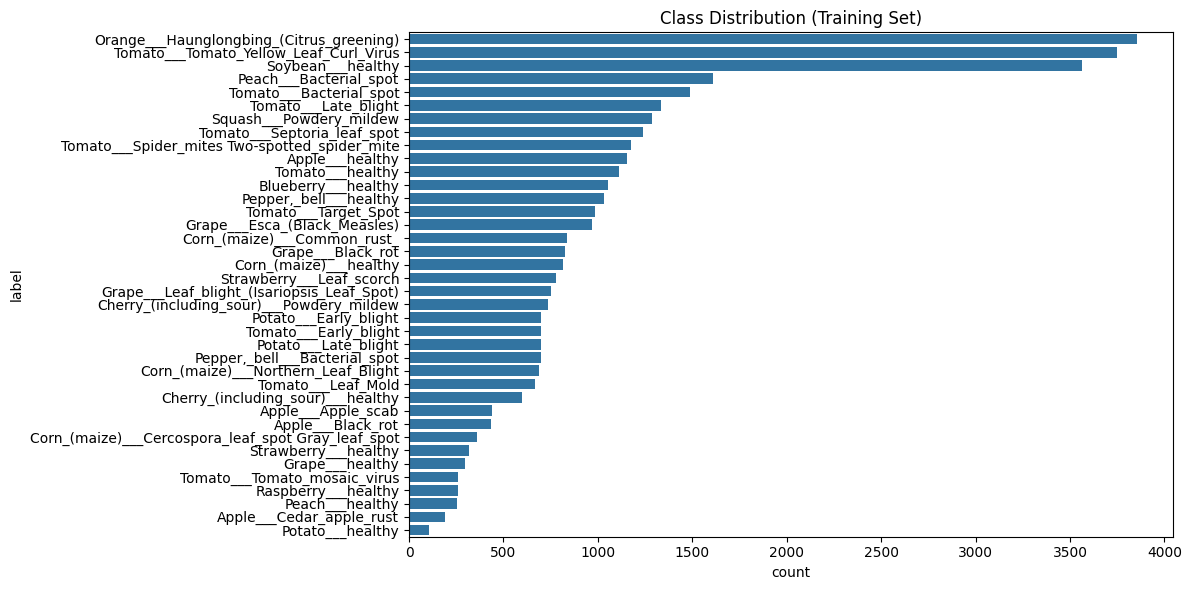

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.countplot(data=train_df, y="label", order=train_df["label"].value_counts().index)
plt.title("Class Distribution (Training Set)")
plt.tight_layout()
plt.show()


##  Notes

- Used only the **PlantVillage color** images.
- Dataset successfully split into train/val/test sets.
- All processed data stored under:

data/
├── processed/
│   └── plantvillage/
│       ├── train/
│       ├── val/
│       ├── test/
│       └── labels.csv
